# Real time anomaly detection with HBOS model

The HBOS model is based on the histogram analysis. This model is imported by the PyOD library and it is integrated in the PySAD model in order to analyze separately windows of input data and encode the time dependency in the model.

In [1]:
import os
import numpy as np
from scipy.io import loadmat
from pyod.models.hbos import HBOS
from pysad.models.integrations import ReferenceWindowModel
from pysad.utils import ArrayStreamer
from pysad.transform.postprocessing import RunningAveragePostprocessor
from pysad.transform.preprocessing import InstanceUnitNormScaler
from pysad.transform.probability_calibration import GaussianTailProbabilityCalibrator
from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import csv
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

import pickle

In [2]:
f = open('../data/netstress_allcontainers/worker_3_stats.csv', 'r', newline='')
reader = csv.reader(f, delimiter=',')
headers = reader.__next__()
X_train = []
time = []
for row in reader:
    time.append(float(row[0]))
    X_train.append([float(o) for o in row[1:]])
X_train = np.array(X_train)
iterator = ArrayStreamer(shuffle=False)

## Hyperparameters and model definition 

In [3]:
window_size = 20
sliding_size = 5

In [4]:
model = ReferenceWindowModel(model_cls=HBOS, window_size=window_size, sliding_size=sliding_size, initial_window_X=X_train[:window_size]) # Model initialization
preprocessor = InstanceUnitNormScaler()  # Normalizer
postprocessor = RunningAveragePostprocessor(window_size=100)  # Running average postprocessor
calibrator = GaussianTailProbabilityCalibrator(running_statistics=True, window_size=len(X_train[:,0]))  # Probability calibrator

## Model training

0it [00:00, ?it/s]

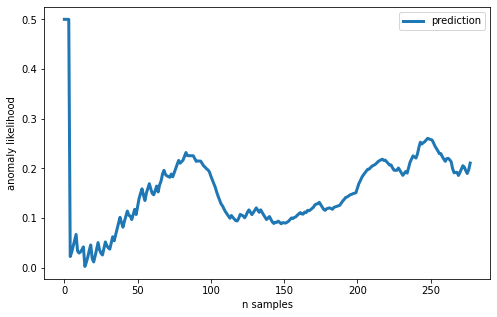

In [5]:
y_pred = []
for i, X in tqdm_notebook(enumerate(iterator.iter(X_train[window_size:]))):
    X = preprocessor.fit_transform_partial(X)
    anomaly_score = model.fit_score_partial(X)
    anomaly_score = postprocessor.fit_transform_partial(anomaly_score)
    calibrated_score = calibrator.fit_transform_partial(anomaly_score)
    y_pred.append(calibrated_score)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(y_pred, label='prediction', linewidth=3)
ax.set_xlabel('n samples')  # Add an x-label to the axes.
ax.set_ylabel('anomaly likelihood')  # Add a y-label to the axes.
ax.legend()
plt.show()

## CPU performance data labelled

In [6]:
pred_mean = np.mean(y_pred)
pred_max = np.max(y_pred)
pred_min = np.min(y_pred)

278


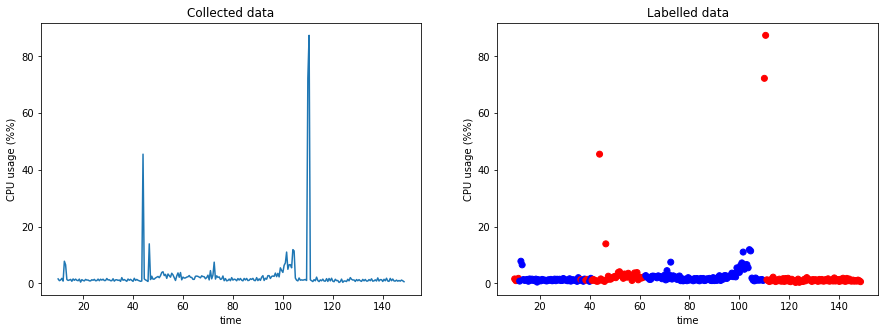

In [7]:
x = time[window_size:]
y = X_train[window_size:,0]
print(len(x))
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax2.set_xlabel('time')  # Add an x-label to the axes.
ax2.set_ylabel('CPU usage (%%)')  # Add a y-label to the axes.
cmap = ListedColormap(['b', 'r'])
norm = BoundaryNorm([pred_min, pred_mean, pred_max], cmap.N)
ax2.scatter(x, y, c=y_pred, cmap=cmap, norm=norm)
ax2.set_title("Labelled data")

ax1.set_title("Collected data")
ax1.set_xlabel('time')  # Add an x-label to the axes.
ax1.set_ylabel('CPU usage (%%)')  # Add a y-label to the axes.
ax1.plot(x,y)
plt.show()

## Memory performance data labelled

278


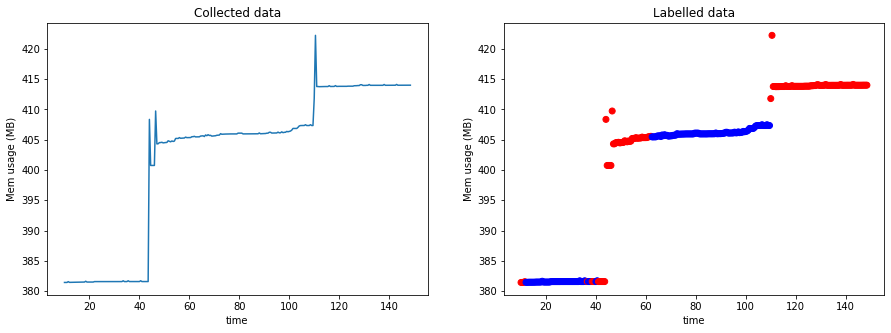

In [8]:
x = time[window_size:]
y = X_train[window_size:,1]
print(len(x))
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax2.set_xlabel('time')  # Add an x-label to the axes.
ax2.set_ylabel('Mem usage (MB)')  # Add a y-label to the axes.
cmap = ListedColormap(['b', 'r'])
norm = BoundaryNorm([pred_min, pred_mean, pred_max], cmap.N)
ax2.scatter(x, y, c=y_pred, cmap=cmap, norm=norm)
ax2.set_title("Labelled data")

ax1.set_title("Collected data")
ax1.set_xlabel('time')  # Add an x-label to the axes.
ax1.set_ylabel('Mem usage (MB)')  # Add a y-label to the axes.
ax1.plot(x,y)
plt.show()

## Network input performance data labelled

278


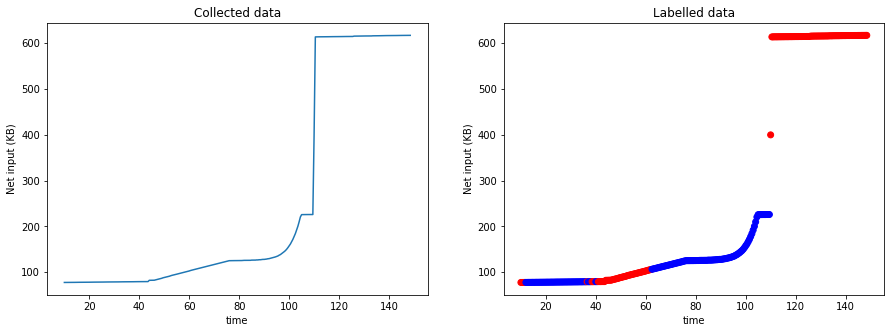

In [9]:
x = time[window_size:]
y = X_train[window_size:,2]
print(len(x))
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax2.set_xlabel('time')  # Add an x-label to the axes.
ax2.set_ylabel('Net input (KB)')  # Add a y-label to the axes.
cmap = ListedColormap(['b', 'r'])
norm = BoundaryNorm([pred_min, pred_mean, pred_max], cmap.N)
ax2.scatter(x, y, c=y_pred, cmap=cmap, norm=norm)
ax2.set_title("Labelled data")

ax1.set_title("Collected data")
ax1.set_xlabel('time')  # Add an x-label to the axes.
ax1.set_ylabel('Net input (KB)')  # Add a y-label to the axes.
ax1.plot(x,y)
plt.show()

## Network output performance data labelled

278


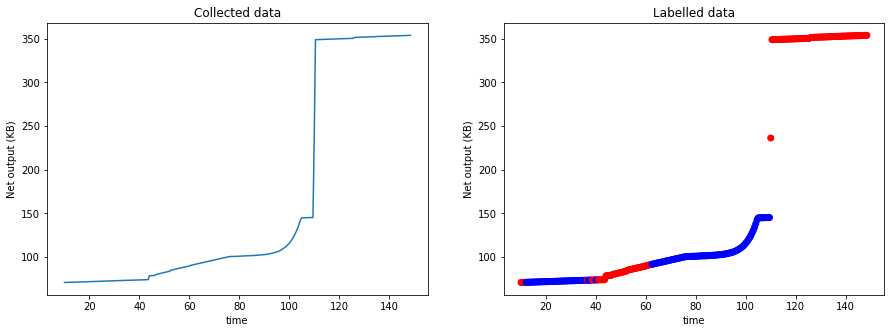

In [10]:
x = time[window_size:]
y = X_train[window_size:,3]
print(len(x))
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax2.set_xlabel('time')  # Add an x-label to the axes.
ax2.set_ylabel('Net output (KB)')  # Add a y-label to the axes.
cmap = ListedColormap(['b', 'r'])
norm = BoundaryNorm([pred_min, pred_mean, pred_max], cmap.N)
ax2.scatter(x, y, c=y_pred, cmap=cmap, norm=norm)
ax2.set_title("Labelled data")

ax1.set_title("Collected data")
ax1.set_xlabel('time')  # Add an x-label to the axes.
ax1.set_ylabel('Net output (KB)')  # Add a y-label to the axes.
ax1.plot(x,y)
plt.show()

## Store the model in external files

This operation is done in order to reuse the model in a second phase externally from this notebook.

In [11]:
pickle.dump(model, open("../models/HBOS/model.sav", "wb"))
pickle.dump(preprocessor, open("../models/HBOS/preprocessor.sav", "wb"))
pickle.dump(postprocessor, open("../models/HBOS/postprocessor.sav", "wb"))
pickle.dump(calibrator, open("../models/HBOS/calibrator.sav", "wb"))